## Classifying Good Product Reviews: Keras Model

### Organize imports

In [1]:
from __future__ import division, print_function, absolute_import
from sklearn.feature_extraction.text import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten, LSTM, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random
import sklearn
import string

Using TensorFlow backend.


### Load and split dataset

Note that the 'review_text' field in the dataset has already been normalized (removed capitalization, punctuation, and stopwords).

In [171]:
def split_train_test(df, test_size):
    train, test = train_test_split(df, test_size=test_size, random_state=random.randint(0, 99))
    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)
    return train, test

dataset_path = 'prepare_new_data/william_combine_data.csv' # Minimized dataset

df = pd.read_csv(dataset_path, sep=',', index_col=0,encoding="ISO-8859-1")

# Training: 60%, Validation: 20%, Testing: 20%
df_train, df_test = split_train_test(df, 0.200)
df_train, df_val = split_train_test(df_train, 0.250)

df.head()

,asin,overall,good,bad,review_text
reviewer_id,,,,,
A30E1NNKCPPZPQ,446579807,1,0,1,unimpressive ramblings reading richard dawkins...
A1IRXCPPMVGIG4,618680004,1,0,1,fall short glory author mortal intellect serve...
A3OX26QQQS51XK,B006R2N8VS,2,0,0,customer service ignores emails apparently unl...
A2APILRM6LRRUC,395169615,1,0,1,nightmarish steam shovel personified enough bo...
A2LYB6RQ35PN8Y,470248424,1,0,0,duper duped duping gullibles man duper duped u...


### Featurize

#### tf-idf

In [172]:
class TfidfFeaturizer(object):
    def __init__(self, col_name='review_text', max_features=1000):
        self.col_name = col_name
        self.max_features = max_features
        self.vectorizer = None
        
    def fit_transform(self, df):
        docs = self.__create_doc_list(df)
        self.vectorizer = TfidfVectorizer(
            analyzer='word',
            ngram_range=(1,3),
            max_features=self.max_features,
            stop_words = 'english'
        )
        return (self.vectorizer.fit_transform(docs)).toarray()

    def transform(self, df):
        if self.vectorizer is not None:
            docs = self.__create_doc_list(df)
            return (self.vectorizer.transform(docs)).toarray()
        else:
            return None

    def __create_doc_list(self, df):
        return df[self.col_name].tolist()

n_tfidf_features = 500
tfidf_featurizer = TfidfFeaturizer(max_features=n_tfidf_features)

print('Fitting tf-idf featurizer.')
tfidf_featurizer.fit_transform(df)

print('Featurizing training set.')
tfidf_train = tfidf_featurizer.transform(df_train)
n_train = tfidf_train.shape[0]
print('Shape:', tfidf_train.shape)

print('Featurizing validation set.')
tfidf_val = tfidf_featurizer.transform(df_val)
n_val = tfidf_val.shape[0]
print('Shape:', tfidf_val.shape)

print('Featurizing test set.')
tfidf_test = tfidf_featurizer.transform(df_test)
n_test = tfidf_test.shape[0]
print('Shape:', tfidf_test.shape)

Fitting tf-idf featurizer.
Featurizing training set.
Shape: (399984, 500)
Featurizing validation set.
Shape: (133329, 500)
Featurizing test set.
Shape: (133329, 500)


In [173]:
matrix_train = tfidf_train
matrix_val   = tfidf_val
matrix_test  = tfidf_test

In [174]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(matrix_train)
matrix_train = scaler.transform(matrix_train)
matrix_val = scaler.transform(matrix_val)
matrix_test = scaler.transform(matrix_test)

### Configure labels

In [175]:
target_class = 'good'

labels_train = np.array(df_train[target_class])
labels_val = np.array(df_val[target_class])
labels_test = np.array(df_test[target_class])

In [176]:
print(len(labels_train))

399984


### Setup Logger

In [177]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []
        self.loss = []
        self.val_loss = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

history = AccuracyHistory()

In [178]:
batch_size = 100
epochs = 30

model = Sequential()
model.add(Dense(64, input_dim=500, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(24, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(matrix_train, labels_train,
          epochs=epochs,
          batch_size=batch_size,
          verbose=0,
          validation_data=(matrix_test, labels_test),
          callbacks=[history])

### Evaluate model on test set

In [179]:
# evaluate the model
score = model.evaluate(matrix_val, labels_val, verbose=0)
print("\n%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])


acc: 72.14%
Validation loss: 0.547136229706
Validation accuracy: 0.72139594537


### Visualize results

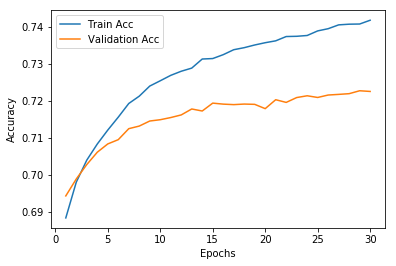

In [180]:
plt.plot(range(1,epochs+1), history.acc, label='Train Acc')
plt.plot(range(1,epochs+1), history.val_acc, label='Validation Acc')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [12]:
# serialize model to JSON
model_json = model.to_json()
with open("prepare_new_data\model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("prepare_new_data\model.h5")
print("Saved model to disk")

Saved model to disk


In [77]:
from keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


# Testing the model

In [19]:
matrix_val.shape

(19638, 300)

In [28]:
a = model.predict(matrix_test)

In [48]:
df_real_test = df[100:130]
df_real_test

,reviewer_id,asin,overall,category,score,good,bad,review_text
100,AO7M9071TCL8U,B00CCILYDA,3,10,0.272727,0,0,question product pause vhs tape playing switch...
101,A1ZQR3EQ7K3LKJ,B005UBNKZG,1,10,0.136364,0,1,needs bulldozer cpus need bulldozer need run b...
102,A2CR57GAJKNWVV,743452402,4,5,0.583333,0,0,good zelazny feel oberon soldier nothing fight...
103,A3711ET9XQ8BKP,1433506254,1,5,0.195652,0,1,christ like mess book makes disturbingly clear...
104,AZ39SOZT3NZQU,891077669,1,5,0.122807,0,1,mental illness book scary putting science soul...
105,A3JBYOHGGXY4N2,B002HEWA2I,5,10,0.840000,1,0,great portable inexpensive camera camera great...
106,A1EYJKNRSGZ4OK,B0007M3PKS,2,10,0.538462,0,0,worth extra money well got model test returnin...
107,A2LH791QCM1W6J,199828075,3,5,0.777778,0,0,ignorance bliss saw short book display table b...
108,A3BAK6H3YS5SC6,981276717,5,5,0.295238,0,0,challenging compelling book caused polarized m...
109,AI2X3LOSONWNS,091103823X,1,5,0.344828,0,0,another holocaust deniers polemic putative his...


In [49]:
print('Featurizing training set.')
tfidf_real_test = tfidf_featurizer.transform(df_real_test)
print('Shape:', tfidf_real_test.shape)

Featurizing training set.
Shape: (30, 300)


In [52]:
result = model.predict_on_batch(tfidf_real_test)

In [53]:
for index, value in enumerate(df_real_test['review_text']):
    print('++ Review:  ',value)
    print('++ Predict: ', result[index], '\n')

++ Review:   question product pause vhs tape playing switch dvd fast forward portion want recorded click vhs button release continue recording thing dvd vhs question let post characters recent version device bought walmart store near house online order still new sucks like reviews question old combo able years using started acting time able record anything check others reviews way recorder trashed viewed photos funai recorded online besides amazon com looking today walmart shopped netgear wifi range extender exactly one sold neighbor since vcr dvd way recorder machine going local walmart store instead waiting shipping online retarded machines question trouble recording shows time warner cable copy right crap since funai made maganvox give minus
++ Predict:  [ 0.34392363] 

++ Review:   needs bulldozer cpus need bulldozer need run bulldozer second new cpus junk unstable even normal levels maybe next version better make cores work time
++ Predict:  [ 0.03859885] 

++ Review:   good zelaz

In [71]:
# Process data of Big file
Big_data = pd.read_csv('data/Big_data.csv', sep=',', index_col=0)
Big_data['review_text'] = Big_data['reviewText']
Big_data.head()

,overall,reviewText,reviewerID,unixReviewTime,Helpfull,Unhelpfull,review_text
asin,,,,,,,
B003UYU16G,5,it is and does exactly what the description sa...,A00000262KYZUE4J55XGL,1353456000,0,0,it is and does exactly what the description sa...
B005FYPK9C,5,i was sketchy at first about these but once yo...,A000008615DZQRRI946FO,1357603200,0,0,i was sketchy at first about these but once yo...
B000VEBG9Y,3,very mobile product. efficient. easy to use; h...,A00000922W28P2OCH6JSE,1395619200,0,0,very mobile product. efficient. easy to use; h...
B001EJMS6K,4,easy to use a mobile. if you're taller than 4f...,A00000922W28P2OCH6JSE,1395619200,0,0,easy to use a mobile. if you're taller than 4f...
B003XJCNVO,4,love this feeder. heavy duty & capacity. best ...,A00000922W28P2OCH6JSE,1395619200,0,0,love this feeder. heavy duty & capacity. best ...


In [72]:
tfidf_big_data = tfidf_featurizer.transform(Big_data)
Big_data['good_review'] = model.predict_on_batch(tfidf_big_data)

In [73]:
Big_data.to_csv('new_data.csv')

## Use k-Fold Cross Validation

In [65]:
X = tfidf_featurizer.transform(df)
Y = np.array(df[target_class])

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
cvscores = []
for train, test in kfold.split(X, Y):
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=300, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    scores = model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

acc: 88.24%
88.24% (+/- 0.00%)


# Tried to use recursive 

In [60]:
df_train, df_test = split_train_test(df, 0.2)

In [66]:
#Train data
matrix_train = tfidf_featurizer.transform(df_train)
matrix_test = tfidf_featurizer.transform(df_test)
#Label data
target_class = 'good'
labels_train = np.array(df_train[target_class])
labels_test = np.array(df_test[target_class])

In [ ]:
import numpy as np
from keras.utils import np_utils
batch_size = 100
epochs = 30

model = Sequential()
X_train = np.reshape(matrix_train, (matrix_train.shape[0], matrix_train.shape[1], 1))
y_train = np_utils.to_categorical(labels_train)
X_test = np.reshape(matrix_test, (matrix_test.shape[0], matrix_test.shape[1], 1))
y_test = np_utils.to_categorical(labels_test)

model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
#model.fit(X, y, epochs=20, batch_size=128, callbacks=callbacks_list)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(X_train, y_train,
          epochs=epochs,
          batch_size=batch_size,
          verbose=0,
          validation_data=(X_test, y_test),
          callbacks=[history])

In [74]:
# evaluate the model
X_val = np.reshape(matrix_val, (matrix_val.shape[0], matrix_val.shape[1], 1))
y_val = np_utils.to_categorical(labels_val)

score = model.evaluate(X_val, y_val, verbose=0)

In [76]:
#print("\n%s: %.2f%%" % (model.metrics_names, score*100))
print('Validation loss:', score)
print('Validation accuracy:', score)

Validation loss: [0.6304680669096433, 0.66560163205617107]
Validation accuracy: [0.6304680669096433, 0.66560163205617107]


In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("prepare_new_data\model_rnn.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("prepare_new_data\model_rnn.h5")
print("Saved model to disk")

In [ ]:
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))
        
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), callbacks=[TestCallback((X_test, Y_test))])

In [183]:
cd C:\Users\s4341237\DeeepSense\Data Library

C:\Users\s4341237\DeeepSense\Data Library


In [145]:
# Create data for Wei
good = []
wei_df = pd.DataFrame()
counter = 0
batchSize = 100

for df in pd.read_csv('final_result.csv', chunksize=batchSize, iterator=True):
    tfidf_real_test = tfidf_featurizer.transform(df)
    good.append(model.predict_on_batch(tfidf_real_test))

In [184]:
df_wei = pd.read_csv('final_result.csv')
tfidf_real_test = tfidf_featurizer.transform(df_wei)

In [185]:
df_wei['good'] = model.predict_on_batch(tfidf_real_test)

In [191]:
df_wei.to_csv('data_wei.csv', sep=',')

In [189]:
df_wei['good_class'] = model.predict_classes(tfidf_real_test)

229536/230251 [============================>.] - ETA: 0s